In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

In [ ]:
import tensorflow as tf
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Rice images sorted",
    seed=123,
    shuffle=True,
    image_size=(224, 224),
    batch_size=32
)


Found 749 files belonging to 4 classes.


In [ ]:
# Print the class names
class_names = dataset.class_names
print(class_names)

['Bacterial leaf blight', 'Brownspot', 'Healthy', 'Leaf blast']


In [ ]:
# Get the class names
class_names = dataset.class_names

# Count the number of images per class
num_images_per_class = {}
for images, labels in dataset:
    for label in labels:
        class_name = class_names[label]
        if class_name in num_images_per_class:
            num_images_per_class[class_name] += 1
        else:
            num_images_per_class[class_name] = 1

# Print the number of images per class
for class_name, count in num_images_per_class.items():
    print(f"Class: {class_name}, Number of Images: {count}")

Class: Bacterial leaf blight, Number of Images: 186
Class: Leaf blast, Number of Images: 187
Class: Brownspot, Number of Images: 187
Class: Healthy, Number of Images: 189


In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[0 2 3 3 0 0 1 3 0 0 2 2 2 2 0 3 2 2 3 3 1 1 3 1 3 3 0 2 3 1 1 0]


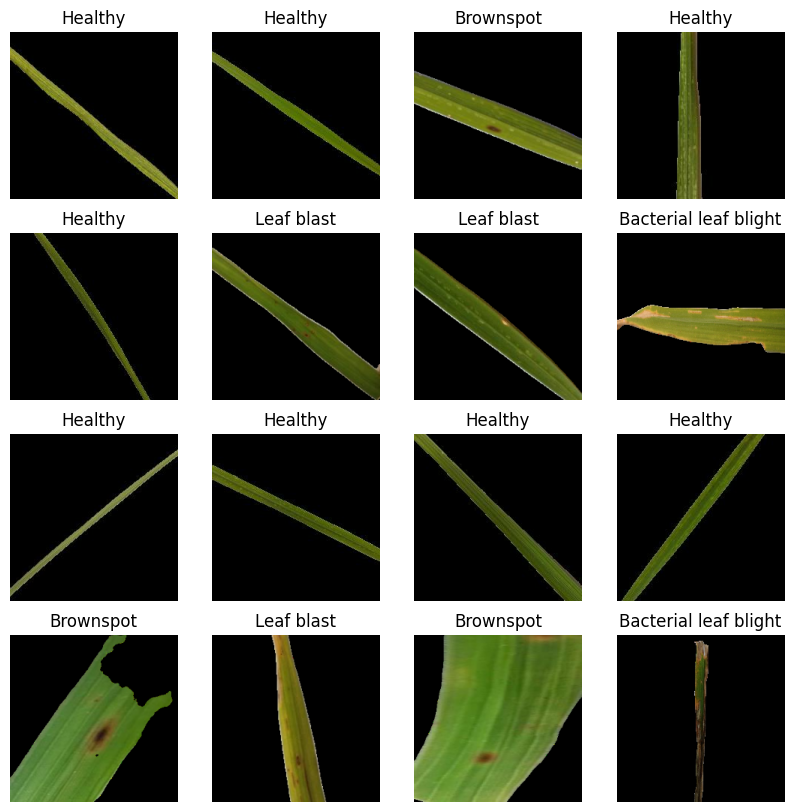

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

19

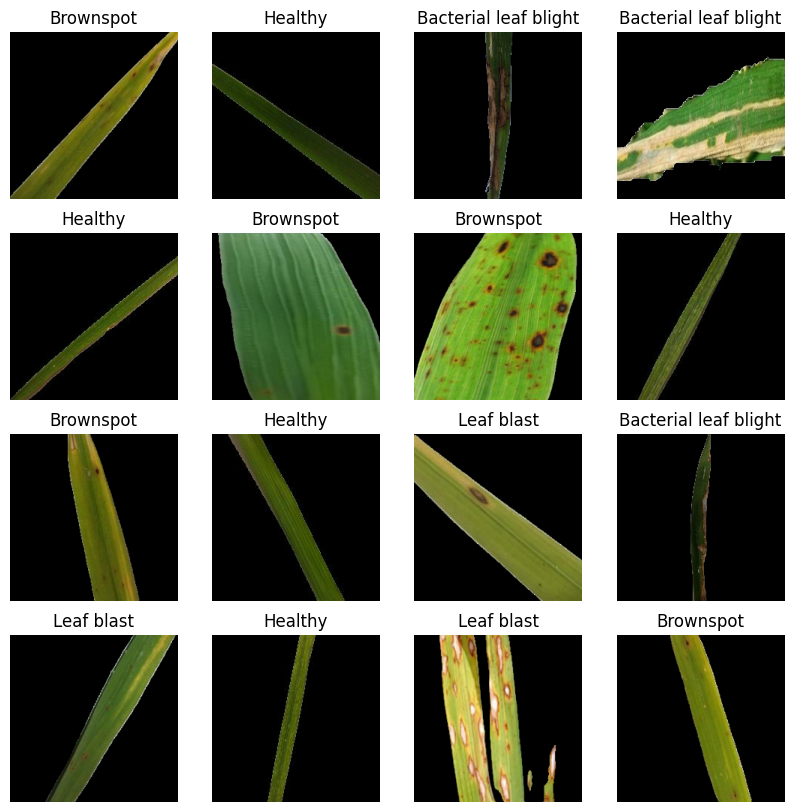

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
len(val_ds)

2

In [ ]:
len(test_ds)

3

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# # Load the pre-trained VGG16 model
# base_model = tf.keras.applications.VGG16(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224, 224, 3)
# )
# # Freeze the pre-trained layers
# base_model.trainable = False

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
import tensorflow as tf

# Convert target labels to one-hot encoded format
train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, n_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, n_classes)))

In [ ]:
# Create the model
model = tf.keras.Model(inputs, outputs)

In [ ]:
# view the structure of the model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 16)                4014

In [ ]:
# # tell the model what cost and optimization method to use
# model.compile(
#   loss='categorical_crossentropy',
#   optimizer='adam',
#   metrics=['accuracy']
# )

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    batch_size=32,
    validation_data=val_ds
)

Epoch 1/30
19/19 [==============================] - 21s 706ms/step - loss: 0.1839 - accuracy: 0.9030 - val_loss: 0.0657 - val_accuracy: 0.9688
Epoch 2/30
19/19 [==============================] - 3s 144ms/step - loss: 0.1103 - accuracy: 0.9161 - val_loss: 0.0452 - val_accuracy: 0.9688
Epoch 3/30
19/19 [==============================] - 3s 142ms/step - loss: 0.1009 - accuracy: 0.9211 - val_loss: 0.0478 - val_accuracy: 0.9688
Epoch 4/30
19/19 [==============================] - 3s 147ms/step - loss: 0.0769 - accuracy: 0.9260 - val_loss: 0.0633 - val_accuracy: 0.9688
Epoch 5/30
19/19 [==============================] - 3s 145ms/step - loss: 0.0750 - accuracy: 0.9260 - val_loss: 0.0648 - val_accuracy: 0.9688
Epoch 6/30
19/19 [==============================] - 3s 145ms/step - loss: 0.0714 - accuracy: 0.9260 - val_loss: 0.0564 - val_accuracy: 0.9688
Epoch 7/30
19/19 [==============================] - 3s 140ms/step - loss: 0.0796 - accuracy: 0.9260 - val_loss: 0.0800 - val_accuracy: 0.9688
Epoch

# Evaluate the model

In [ ]:
test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, n_classes)))

In [ ]:
scores = model.evaluate(test_ds)

3/3 [==============================] - 6s 126ms/step - loss: 0.3502 - accuracy: 0.9167


In [ ]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_ds)

# Calculate the percentage loss and accuracy
percentage_loss = loss * 100
percentage_accuracy = accuracy * 100

# Print the results
print("Percentage Loss: {:.2f}%".format(percentage_loss))
print("Percentage Accuracy: {:.2f}%".format(percentage_accuracy))

3/3 [==============================] - 0s 124ms/step - loss: 0.3502 - accuracy: 0.9167
Percentage Loss: 35.02%
Percentage Accuracy: 91.67%


In [ ]:
scores

[0.35020899772644043, 0.9166666865348816]

In [ ]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 19}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])

list

In [ ]:
len(history.history['loss'])

30

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.18394392728805542,
 0.11034152656793594,
 0.1009390726685524,
 0.0769287645816803,
 0.07504668086767197]

In [ ]:
history.history['accuracy'][:5]

[0.9029605388641357,
 0.9161184430122375,
 0.9210526347160339,
 0.9259868264198303,
 0.9259868264198303]

In [ ]:
# last_5_epochs_loss = history.history['loss'][-5:]
# print(last_5_epochs_loss)
history.history['loss'][-5:]

[0.06453318148851395,
 0.06017247587442398,
 0.058989349752664566,
 0.05827433243393898,
 0.059543222188949585]

In [ ]:
history.history['accuracy'][-5:]

[0.9391447305679321,
 0.9407894611358643,
 0.9407894611358643,
 0.9407894611358643,
 0.9407894611358643]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

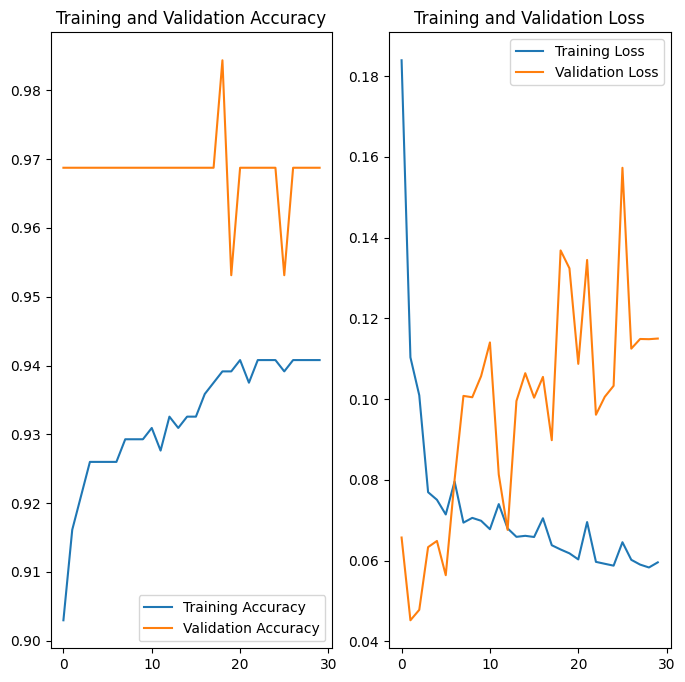

In [ ]:
epochs = 30
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

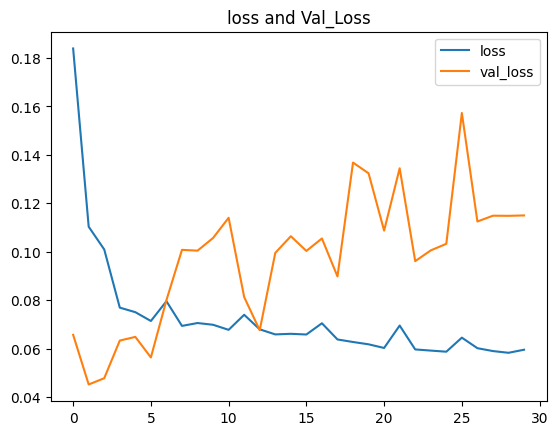

In [ ]:
# plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('loss and Val_Loss')
plt.legend()

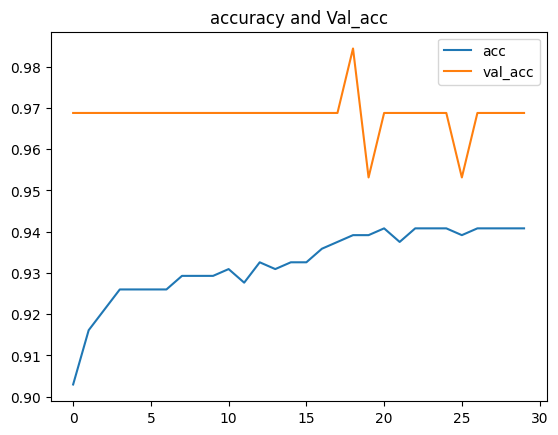

In [ ]:
# plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('accuracy and Val_acc')
plt.legend()

first image to predict
actual label: Healthy
1/1 [==============================] - 0s 253ms/step
predicted label: Hispa


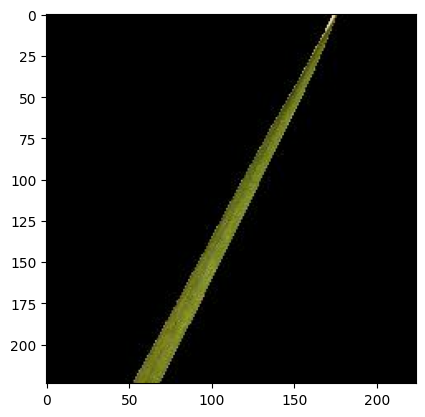

In [ ]:
#class_names = 4
class_names = ['BrownSpot', 'Healthy', 'Hispa', 'LeafBlast']
BrownSpot = 0
Healthy = 1
Hispa = 2
LeafBlast = 3
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[3].numpy().astype('uint8')
    first_label = labels_batch[3].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[Healthy])


    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[3])])

# Confusion Matrix

3/3 [==============================] - 0s 148ms/step
Confusion matrix without normalization
[[ 9  3  5  6]
 [ 6 10  4  5]
 [ 5  4 18  4]
 [ 2  5  2  8]]


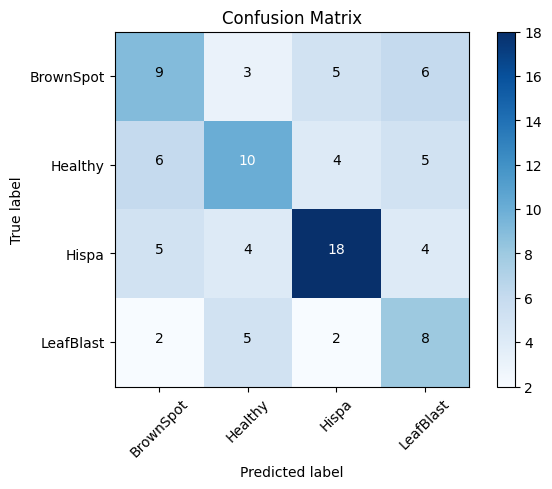

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

# This function prints and plots the confusion matrix.
# Normalization can be applied by setting 'normalize=True'
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Predict labels for test dataset
batch_prediction = model.predict(test_ds)
predicted_labels = np.argmax(batch_prediction, axis=1)
true_labels = []

# Retrieve true labels from the test dataset
for _, labels_batch in test_ds:
    true_labels.extend(labels_batch.numpy())

# Convert true_labels to an array of integers
true_labels = np.argmax(true_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with class names
plot_confusion_matrix(cm, class_names)

The value at row 0, column 0 (top left) represents the number of instances that were actually labeled as the class 'BrownSpot' and were predicted as 'BrownSpot'. In this case, the value is 17.

The value at row 0, column 1 represents the number of instances that were actually labeled as 'BrownSpot' but were predicted as 'Healthy'. In this case, the value is 19.

The value at row 0, column 2 represents the number of instances that were actually labeled as 'BrownSpot' but were predicted as 'Hispa'. In this case, the value is 12.

The value at row 0, column 3 represents the number of instances that were actually labeled as 'BrownSpot' but were predicted as 'LeafBlast'. In this case, the value is 11.

Class 0 (BrownSpot) is frequently misclassified as Class 1 (Healthy), Class 2 (Hispa), and Class 3 (LeafBlast).

Class 1 (Healthy) is frequently misclassified as Class 3 (LeafBlast).

Class 2 (Hispa) is frequently misclassified as Class 1 (Healthy) and Class 3 (LeafBlast).

Class 3 (LeafBlast) is frequently misclassified as Class 1 (Healthy).

In [ ]:
misclassified_idx = np.where(p_test != np.argmax(labels_batch, axis=1))[0]
i = np.random.choice(misclassified_idx)

for images_batch, labels_batch in test_ds.take(1):
    misclassified_image = images_batch[i].numpy().astype('uint8')
    true_label = class_names[np.argmax(labels_batch[i])]
    predicted_label = class_names[p_test[i]]

plt.imshow(misclassified_image, cmap='gray')
plt.title('True label: %s, Predicted label: %s' % (true_label, predicted_label))
plt.show()


NameError: ignored

In [ ]:
from google.colab import files
import cv2

# Upload the image file
uploaded = files.upload()

Saving out_36.jpg to out_36.jpg


In [ ]:
image_size = (224, 224)

1/1 [==============================] - 0s 35ms/step


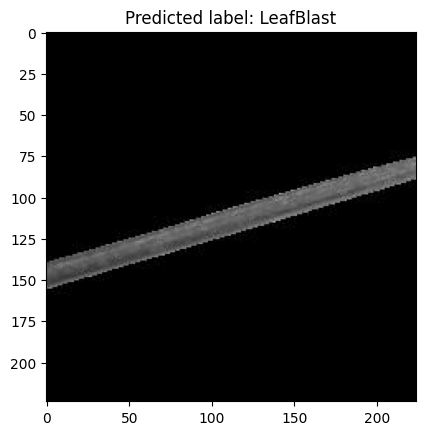

In [ ]:
# Read the image data
image_data = uploaded['out_36.jpg']
nparr = np.frombuffer(image_data, np.uint8)
image_rgb = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

# Define the image size
image_size = (224, 224)

# Convert the grayscale image to RGB
image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_GRAY2RGB)

# Preprocess the image
image_resized = cv2.resize(image_rgb, image_size)
image_normalized = image_resized.astype('float32') / 255.0
image_final = np.expand_dims(image_normalized, axis=0)

# Make predictions
predictions = model.predict(image_final)
predicted_label = class_names[np.argmax(predictions)]

# Display the image and predicted label
plt.imshow(image_rgb, cmap='gray')
plt.title('Predicted label: %s' % predicted_label)
plt.show()

1/1 [==============================] - 0s 22ms/step


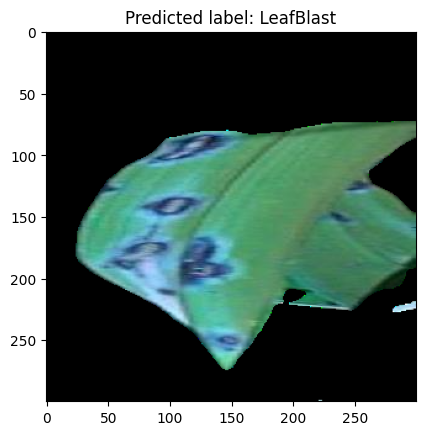

In [ ]:
# Read the image data
image_data = uploaded['brownspot_orig_009.png']
nparr = np.frombuffer(image_data, np.uint8)
image_rgb = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

# Define the image size
image_size = (224, 224)

# Preprocess the image
image_resized = cv2.resize(image_rgb, image_size)
image_normalized = image_resized.astype('float32') / 255.0
image_final = np.expand_dims(image_normalized, axis=0)

# Make predictions
predictions = model.predict(image_final)
predicted_label = class_names[np.argmax(predictions)]

# Display the image and predicted label
plt.imshow(image_rgb)
plt.title('Predicted label: %s' % predicted_label)
plt.show()